In [1]:
import pandas as pd
import selfies as sf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from collections import Counter
import seaborn as sns
import torch
from torch.utils.data import Dataset
import torch.nn as nn
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import csv
import selfies as sf
from collections import Counter
import torch.nn as nn
import csv
import os
import pandas as pd
from cddd.inference import InferenceModel
from cddd.preprocessing import preprocess_smiles
from scipy.ndimage import gaussian_filter

In [2]:
!python3 example/run_qsar_test.py --model_dir cddd/pretrained_models/default_model


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0616 06:31:32.129397 134383162566144 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Traceback (most recent call last):
  File "example/run_qsar_test.py", line 94, in <module>
    tf.app.run(main=main, argv=[sys.argv[0]] + UNPARSED)
  File "/home/undergrad/2026/melkoudi/miniconda3/envs/tf110/lib/p

In [3]:
!cddd --input smiles.smi --output descriptors.csv  --smiles_header smiles


/home/undergrad/2026/melkoudi/miniconda3/envs/tf110/lib/python3.6/site-packages/cddd/run_cddd.py:55: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  sml_df = pd.read_table(file, header=None).rename({0:FLAGS.smiles_header, 1:"EXTREG"},
Traceback (most recent call last):
  File "/home/undergrad/2026/melkoudi/miniconda3/envs/tf110/bin/cddd", line 8, in <module>
    sys.exit(main_wrapper())
  File "/home/undergrad/2026/melkoudi/miniconda3/envs/tf110/lib/python3.6/site-packages/cddd/run_cddd.py", line 99, in main_wrapper
    tf.app.run(main=main, argv=[sys.argv[0]] + UNPARSED)
  File "/home/undergrad/2026/melkoudi/miniconda3/envs/tf110/lib/python3.6/site-packages/tensorflow_core/python/platform/app.py", line 40, in run
    _run(main=main, argv=argv, flags_parser=_parse_flags_tolerate_undef)
  File "/home/undergrad/2026/melkoudi/miniconda3/envs/tf110/lib/python3.6/site-packages/absl/app.py", line 308, in run
    _run_main(main, args)
  File "/home/undergra

# Smiles Embedding:
### Use cddd to encode smiles (yippeeee)

In [4]:
# create a smiles list of 6000
smiles_list = []

with open("computed_spectra.csv", "r") as f:
    reader = csv.reader(f)
    next(reader)  # skip header line
    for i, row in enumerate(reader):
        if i >= 6000:
            break
        smiles = row[0].strip()
        try:
            smiles_list.append(smiles)
        except:
            continue

# make instance of autoencoder model
inference_model = InferenceModel(model_dir="cddd/data/default_model")

# embed the smiles
# Get 512-dim CDDD embeddings
smiles_embedding = inference_model.seq_to_emb(smiles_list)


# print example to see if it works
for i in range(5):
    print(f"SMILES: {smiles_list[i]}") # full smiles
    print(f"Embedding: {smiles_embedding[i][:10]}...\n")  # print first 10 values of the embedding



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.







Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument in

# Normalize & Smooth Spectra

In [5]:
import numpy as np
from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler


spec_len = 1801 
spectra_list = []

with open("computed_spectra.csv", "r") as f:
    reader = csv.reader(f)
    next(reader)
    for i, row in enumerate(reader):
        if i >= 6000:
            break
        try:
            spectrum = [float(x) for x in row[1:]]
            if len(spectrum) == spec_len:
                spectra_list.append(spectrum)
        except:
            continue


# conver to np array
spectra_array = np.array(spectra_list)

# normalize
scaler = MinMaxScaler()
normalized_spectra = scaler.fit_transform(spectra_array)

# check if normalization worked 
print("Normalized spectra shape:", normalized_spectra.shape)
print("Sample normalized spectrum:", normalized_spectra[0][:10])

# Smooth each spectrum
smoothed_spectra = [savgol_filter(spectrum, window_length=15, polyorder=3) for spectrum in normalized_spectra]

# covert back to np array
smoothed_spectra = np.array(smoothed_spectra)
Y = smoothed_spectra 

# check if smoothing worked
print("Smoothed spectra shape:", smoothed_spectra.shape)
print("Example smoothed spectrum:", smoothed_spectra[0][:10])


Normalized spectra shape: (3568, 1801)
Sample normalized spectrum: [0.10808033 0.10908509 0.1097319  0.11094673 0.11241841 0.11278684
 0.11332587 0.11278429 0.11410056 0.11418134]
Smoothed spectra shape: (3568, 1801)
Example smoothed spectrum: [0.10755056 0.10928005 0.11052331 0.11138647 0.11197562 0.11239689
 0.11275636 0.11316016 0.11389765 0.11500437]


# Pad Smiles

In [6]:
"""def pad_embeddings(embeddings, target_dim=1802):
    current_dim = embeddings.shape[1]
    if current_dim >= target_dim:
        return embeddings[:, :target_dim]  # truncate if too long
    padding = np.ones((embeddings.shape[0], target_dim - current_dim*2))*2
    return np.concatenate([embeddings, padding, embeddings], axis=1)

X_padded = pad_embeddings(smiles_embedding, target_dim=1802)  # shape (6000, 1801)
"""

"""def pad_to_even_dim(arr, target_dim=1802):
    if arr.shape[1] < target_dim:
        padding = np.ones((arr.shape[0], target_dim - arr.shape[1]))
        return np.concatenate([arr, padding], axis=1)
    else:
        return arr[:, :target_dim]"""

import numpy as np
"""
def pad_embeddings(embeddings, target_dim=1802):
    
    Pads embeddings by placing a zero-filled gap between two copies of the embeddings.
    Final shape: [embeddings | zeros | embeddings]
    
    current_dim = embeddings.shape[1]
    if 2 * current_dim > target_dim:
        raise ValueError(f"Embedding dimension too large for target_dim. Got {current_dim}, expected ≤ {target_dim//2}")
    
    gap_dim = target_dim - 2 * current_dim
    zeros = np.ones((embeddings.shape[0], gap_dim))
    return np.concatenate([embeddings, zeros, embeddings], axis=1)
    """

def pad_embeddings(embeddings, target_dim=1802):
    current_dim = embeddings.shape[1]
    if 2 * current_dim > target_dim:
        raise ValueError("Embedding too large")
    gap = target_dim - 2 * current_dim
    zeros = np.zeros((embeddings.shape[0], gap))
    return np.concatenate([embeddings, zeros, embeddings], axis=1)

X_padded = pad_embeddings(smiles_embedding, target_dim=1802)  # for forward
X_raw = smiles_embedding  # for reverse



# Split into train & test sets :)

In [7]:
from sklearn.model_selection import train_test_split

min_len = min(len(X_padded), len(Y))
X_padded = X_padded[:min_len]  # for forward
X_raw = X_raw[:min_len]        # for reverse
Y = Y[:min_len]

Xf_train, Xf_test, Xr_train, Xr_test, Y_train, Y_test = train_test_split(
    X_padded, X_raw, Y, test_size=0.2, random_state=42
)

# forward (X_padded | Y)
Z_train = np.concatenate([Xf_train, Y_train], axis=1)
Z_test = np.concatenate([Xf_test, Y_test], axis=1)

# Reverse (Y | X_raw)
Z_train_rev = np.concatenate([Y_train, Xr_train], axis=1)
Z_test_rev = np.concatenate([Y_test, Xr_test], axis=1)

# Dataset:

In [8]:
from torch.utils.data import Dataset, DataLoader
import torch

class SmilesSpectraDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

# forward DataLoaders
train_loader = DataLoader(SmilesSpectraDataset(Z_train), batch_size=64, shuffle=True)
test_loader = DataLoader(SmilesSpectraDataset(Z_test), batch_size=64)

# reverse DataLoaders
train_loader_rev = DataLoader(SmilesSpectraDataset(Z_train_rev), batch_size=64, shuffle=True)
test_loader_rev = DataLoader(SmilesSpectraDataset(Z_test_rev), batch_size=64)


In [8]:
"""sample = torch.tensor(Z_train[0][:1802], dtype=torch.float32).reshape((-1, 1802))
print(sample.shape)
sample2 = torch.rand((32, 1802))
print(sample[:,512:1024])
model(sample2)

"""

'sample = torch.tensor(Z_train[0][:1802], dtype=torch.float32).reshape((-1, 1802))\nprint(sample.shape)\nsample2 = torch.rand((32, 1802))\nprint(sample[:,512:1024])\nmodel(sample2)\n\n'

In [15]:
class SIDLoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps

    def forward(self, model_spectra, target_spectra):
        model_spectra = torch.clamp(model_spectra, min=self.eps)
        target_spectra = torch.clamp(target_spectra, min=self.eps)

        term1 = model_spectra * torch.log(model_spectra / target_spectra)
        term2 = target_spectra * torch.log(target_spectra / model_spectra)
        loss = term1 + term2
        return loss.sum(dim=1).mean()

In [47]:

    """for batch in train_loader:
        break
    x_batch = batch[:, :1802]
    y_batch = batch[:, 1802:]
    optimizer.zero_grad()
    y_pred = model(x_batch)
    print(y_pred[:, 900:])"""

'for batch in train_loader:\n    break\nx_batch = batch[:, :1802]\ny_batch = batch[:, 1802:]\noptimizer.zero_grad()\ny_pred = model(x_batch)\nprint(y_pred[:, 900:])'

# INN Model: (RealNVP)

In [61]:
from torch.nn import BatchNorm1d

class CouplingLayer(nn.Module):
    def __init__(self, dim):
        super().__init__()
        hidden = 512
        self.scale = nn.Sequential(
            nn.Linear(dim // 2, hidden),
            BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden, dim // 2),
            nn.Tanh()
        )
        self.translate = nn.Sequential(
            nn.Linear(dim // 2, hidden),
            BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden, dim // 2)
        )
    def forward(self, x, reverse=False):
        x1, x2 = x.chunk(2, dim=1)
        s, t = self.scale(x1), self.translate(x1)
        y2 = x2 * torch.exp(s) + t if not reverse else (x2 - t) * torch.exp(-s)
        return torch.cat([x1, y2], dim=1)

class RealNVP(nn.Module):
    def __init__(self, dim, num_layers=3):
        super().__init__()
        self.layers = nn.ModuleList([CouplingLayer(dim) for _ in range(num_layers)])
    def forward(self, x, reverse=False):
        for layer in (self.layers if not reverse else reversed(self.layers)):
            x = layer(x, reverse=reverse)
        return x

class RealNVPWithProjection(nn.Module):
    def __init__(self, dim, output_dim=1801, num_layers=3):
        super().__init__()
        self.flow = RealNVP(dim, num_layers)
        self.project = nn.Sequential(
            nn.Linear(dim, output_dim),
            nn.Tanh()
        )

    def forward(self, x, reverse=False):
        x = self.flow(x, reverse=reverse)
        if not reverse:
            x = self.project(x)
        return x
        
# forward model
model = RealNVPWithProjection(dim=1802, output_dim=1801, num_layers=10)

# reverse model
reverse_model = RealNVPWithProjection(dim=1800, output_dim=512)

# optimizers
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
reverse_optimizer = torch.optim.Adam(reverse_model.parameters(), lr=1e-3)

# Training Loop

In [62]:
input_dim = 1802
loss_fn = nn.MSELoss()

train_losses = []
test_losses = []

for epoch in range(20):
    model.train()
    total_loss = 0
    for batch in train_loader:
        x_batch = batch[:, :1802]
        y_batch = batch[:, 1802:]
        optimizer.zero_grad()
        y_pred = model(x_batch)
        #loss = loss_fn(y_pred[:, :1801], y_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss)

    model.eval()
    with torch.no_grad():
        test_loss = 0
        for batch in test_loader:
            x_batch = batch[:, :1802]
            y_batch = batch[:, 1802:]
            y_pred = model(x_batch)
            test_loss += loss_fn(y_pred, y_batch).item()
        test_losses.append(test_loss)

    print(f"Epoch {epoch+1}: Train Loss = {total_loss:.4f}, Test Loss = {test_loss:.4f}")


Epoch 1: Train Loss = 1.3483, Test Loss = 0.1021
Epoch 2: Train Loss = 0.3700, Test Loss = 0.0719
Epoch 3: Train Loss = 0.2773, Test Loss = 0.0640
Epoch 4: Train Loss = 0.2391, Test Loss = 0.0615
Epoch 5: Train Loss = 0.2169, Test Loss = 0.0599
Epoch 6: Train Loss = 0.2027, Test Loss = 0.0574
Epoch 7: Train Loss = 0.1914, Test Loss = 0.0576
Epoch 8: Train Loss = 0.1850, Test Loss = 0.0562
Epoch 9: Train Loss = 0.1751, Test Loss = 0.0556
Epoch 10: Train Loss = 0.1691, Test Loss = 0.0562
Epoch 11: Train Loss = 0.1644, Test Loss = 0.0560
Epoch 12: Train Loss = 0.1577, Test Loss = 0.0559
Epoch 13: Train Loss = 0.1528, Test Loss = 0.0550
Epoch 14: Train Loss = 0.1462, Test Loss = 0.0560
Epoch 15: Train Loss = 0.1433, Test Loss = 0.0558
Epoch 16: Train Loss = 0.1374, Test Loss = 0.0555
Epoch 17: Train Loss = 0.1328, Test Loss = 0.0562
Epoch 18: Train Loss = 0.1273, Test Loss = 0.0552
Epoch 19: Train Loss = 0.1239, Test Loss = 0.0554
Epoch 20: Train Loss = 0.1213, Test Loss = 0.0553


In [18]:
"""input_dim = 1802
model = RealNVP(dim=input_dim, num_layers=3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = SIDLoss()
"""

In [29]:
"""s1 = torch.rand((32,1802))
s1 = s1/10000
model(s1)"""

's1 = torch.rand((32,1802))\ns1 = s1/10000\nmodel(s1)'

# Model Evaluation 

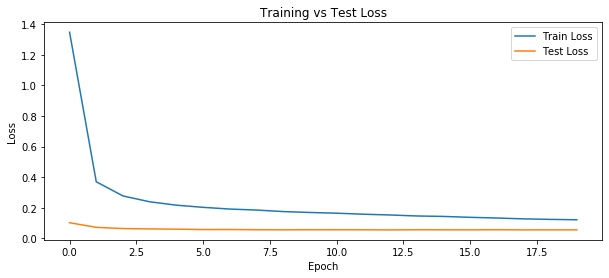

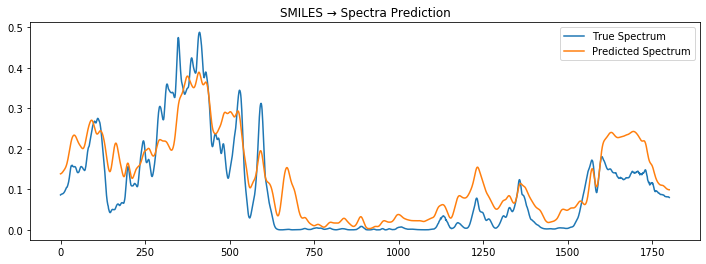

In [63]:
# plot loss graph
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Test Loss")
plt.legend()
plt.show()

# Collect test set into X_test and Y_test
X_test_list = []
Y_test_list = []

for batch in test_loader:
    x = batch[:, :1802]
    y = batch[:, 1802:]
    X_test_list.append(x)
    Y_test_list.append(y)

X_test = torch.cat(X_test_list, dim=0).numpy()
Y_test = torch.cat(Y_test_list, dim=0).numpy()

# plot predicted vs true spectrum
model.eval()
with torch.no_grad():
    y_pred_test = model(torch.tensor(X_test, dtype=torch.float32)).numpy()

y_pred_test = gaussian_filter(y_pred_test, sigma=5)

idx = 100
plt.figure(figsize=(12, 4))
plt.plot(Y_test[idx], label="True Spectrum")
plt.plot(y_pred_test[idx], label="Predicted Spectrum")
plt.title("SMILES → Spectra Prediction")
plt.legend()
plt.show()


# Reversing the INN :)

## Reverse Training Loop 

In [64]:
from torch.nn import MSELoss

reverse_loss_fn = MSELoss()

rev_train_losses = []
rev_test_losses = []

for epoch in range(100):
    reverse_model.train()
    total_loss = 0
    for batch in train_loader_rev:
        spectra = batch[:, :1801]  # full padded spectra
        spectra_cropped = torch.cat([spectra[:, :900], spectra[:, 901:]], dim=1)  # remove zero middle → 900-dim
        true_embeddings = batch[:, 1801:]  # target: 512-dim padded embeddings

        reverse_optimizer.zero_grad()
        pred_embeddings = reverse_model(spectra_cropped, reverse=False)  # expects 900 input
        loss = reverse_loss_fn(pred_embeddings, true_embeddings[:, :512])  # compare against true 512-dim
        loss.backward()
        reverse_optimizer.step()
        total_loss += loss.item()
    
    rev_train_losses.append(total_loss)

    reverse_model.eval()
    with torch.no_grad():
        test_loss = 0
        for batch in test_loader_rev:
            spectra = batch[:, :1801]
            spectra_cropped = torch.cat([spectra[:, :900], spectra[:, 901:]], dim=1)
            true_embeddings = batch[:, 1801:]
            pred_embeddings = reverse_model(spectra_cropped, reverse=False)
            test_loss += reverse_loss_fn(pred_embeddings, true_embeddings[:, :512]).item()
        rev_test_losses.append(test_loss)

    print(f"[Reverse Epoch {epoch+1}] Train Loss: {total_loss:.4f}, Test Loss: {test_loss:.4f}")


[Reverse Epoch 1] Train Loss: 8.4261, Test Loss: 1.9954
[Reverse Epoch 2] Train Loss: 7.2638, Test Loss: 1.8920
[Reverse Epoch 3] Train Loss: 6.9197, Test Loss: 1.8427
[Reverse Epoch 4] Train Loss: 6.6493, Test Loss: 1.8447
[Reverse Epoch 5] Train Loss: 6.4243, Test Loss: 1.7982
[Reverse Epoch 6] Train Loss: 6.2622, Test Loss: 1.7697
[Reverse Epoch 7] Train Loss: 6.1101, Test Loss: 1.7689
[Reverse Epoch 8] Train Loss: 6.0199, Test Loss: 1.7600
[Reverse Epoch 9] Train Loss: 5.8606, Test Loss: 1.7354
[Reverse Epoch 10] Train Loss: 5.7247, Test Loss: 1.7323
[Reverse Epoch 11] Train Loss: 5.5938, Test Loss: 1.7426
[Reverse Epoch 12] Train Loss: 5.4703, Test Loss: 1.7436
[Reverse Epoch 13] Train Loss: 5.3529, Test Loss: 1.7361
[Reverse Epoch 14] Train Loss: 5.2224, Test Loss: 1.7321
[Reverse Epoch 15] Train Loss: 5.1073, Test Loss: 1.7492
[Reverse Epoch 16] Train Loss: 4.9458, Test Loss: 1.7495
[Reverse Epoch 17] Train Loss: 4.8287, Test Loss: 1.7395
[Reverse Epoch 18] Train Loss: 4.7139, T

## Reverse Training Loop (With Early Stopping)

In [72]:
from torch.nn import SmoothL1Loss
from torch.optim.lr_scheduler import ReduceLROnPlateau

reverse_loss_fn = SmoothL1Loss()
rev_train_losses = []
rev_test_losses = []

best_test_loss = float('inf')
epochs_no_improve = 0
patience = 15
min_delta = 1e-4
max_epochs = 500
best_model_state = None

# learning rate scheduler
reverse_scheduler = ReduceLROnPlateau(reverse_optimizer, mode='min', factor=0.5, patience=5, verbose=True)

for epoch in range(max_epochs):
    reverse_model.train()
    total_loss = 0
    for batch in train_loader_rev:
        spectra = batch[:, :1801]
        spectra_cropped = torch.cat([spectra[:, :900], spectra[:, 901:]], dim=1)
        true_embeddings = batch[:, 1801:]

        reverse_optimizer.zero_grad()
        pred_embeddings = reverse_model(spectra_cropped, reverse=False)
        loss = reverse_loss_fn(pred_embeddings, true_embeddings[:, :512])
        loss.backward()
        reverse_optimizer.step()
        total_loss += loss.item()

    rev_train_losses.append(total_loss)

    # eval phase
    reverse_model.eval()
    with torch.no_grad():
        test_loss = 0
        for batch in test_loader_rev:
            spectra = batch[:, :1801]
            spectra_cropped = torch.cat([spectra[:, :900], spectra[:, 901:]], dim=1)
            true_embeddings = batch[:, 1801:]
            pred_embeddings = reverse_model(spectra_cropped, reverse=False)
            test_loss += reverse_loss_fn(pred_embeddings, true_embeddings[:, :512]).item()
        rev_test_losses.append(test_loss)

    # step scheduler
    reverse_scheduler.step(test_loss)

    print(f"[Reverse Epoch {epoch+1}] Train Loss: {total_loss:.4f}, Test Loss: {test_loss:.4f}")

    # early stopping
    if best_test_loss - test_loss > min_delta:
        best_test_loss = test_loss
        epochs_no_improve = 0
        best_model_state = reverse_model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1} (no improvement in {patience} epochs)")
            break

# restore best model
if best_model_state is not None:
    reverse_model.load_state_dict(best_model_state)
    print("Best model restored.")


[Reverse Epoch 1] Train Loss: 0.6238, Test Loss: 0.9289
[Reverse Epoch 2] Train Loss: 0.6203, Test Loss: 0.9275
[Reverse Epoch 3] Train Loss: 0.6099, Test Loss: 0.9292
[Reverse Epoch 4] Train Loss: 0.6209, Test Loss: 0.9278
[Reverse Epoch 5] Train Loss: 0.6203, Test Loss: 0.9279
[Reverse Epoch 6] Train Loss: 0.6178, Test Loss: 0.9268
[Reverse Epoch 7] Train Loss: 0.6149, Test Loss: 0.9294
[Reverse Epoch 8] Train Loss: 0.6182, Test Loss: 0.9286
[Reverse Epoch 9] Train Loss: 0.6198, Test Loss: 0.9274
[Reverse Epoch 10] Train Loss: 0.6151, Test Loss: 0.9310
[Reverse Epoch 11] Train Loss: 0.6141, Test Loss: 0.9278
Epoch    11: reducing learning rate of group 0 to 7.8125e-06.
[Reverse Epoch 12] Train Loss: 0.6145, Test Loss: 0.9305
[Reverse Epoch 13] Train Loss: 0.6176, Test Loss: 0.9327
[Reverse Epoch 14] Train Loss: 0.6191, Test Loss: 0.9315
[Reverse Epoch 15] Train Loss: 0.6186, Test Loss: 0.9298
[Reverse Epoch 16] Train Loss: 0.6144, Test Loss: 0.9315
[Reverse Epoch 17] Train Loss: 0.61

## Model Evaluation (Dun Dun Daaaahhh...)

## Training Loss (Revere Model):

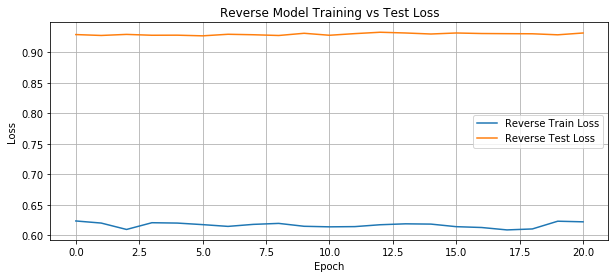

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(rev_train_losses, label="Reverse Train Loss")
plt.plot(rev_test_losses, label="Reverse Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Reverse Model Training vs Test Loss")
plt.legend()
plt.grid(True)
plt.show()


In [74]:
import torch
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
from difflib import SequenceMatcher

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')  # disables all RDKit warnings/errors

# get predicted embeddings from test spectra
reverse_model.eval()
with torch.no_grad():
    test_spectra_tensor = torch.tensor(Y_test[:, :1800], dtype=torch.float32)  # crop if needed
    predicted_embeddings = reverse_model(test_spectra_tensor, reverse=False).cpu().numpy()

# decode predicted embeddings to SMILES using your inference model
predicted_smiles = inference_model.emb_to_seq(predicted_embeddings[:, :512])

# get true SMILES that correspond to Y_test
_, smiles_test = train_test_split(smiles_list, test_size=0.2, random_state=42)

# compute tanimoto similarity
def tanimoto(s1, s2):
    try:
        mol1 = Chem.MolFromSmiles(s1)
        mol2 = Chem.MolFromSmiles(s2)
        if mol1 is None or mol2 is None:
            return 0.0
        fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 2)
        fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 2)
        return DataStructs.TanimotoSimilarity(fp1, fp2)
    except:
        return 0.0

# compute syntax similarity
def syntax_similarity(s1, s2):
    return SequenceMatcher(None, s1, s2).ratio()

# compare true vs predicted SMILES
valid_count = 0

for i in range(10):
    true_smi = smiles_test[i]
    pred_smi = predicted_smiles[i]

    is_valid = Chem.MolFromSmiles(pred_smi) is not None
    if is_valid:
        valid_count += 1

    tanimoto_sim = tanimoto(true_smi, pred_smi)
    syntax_sim = syntax_similarity(true_smi, pred_smi)

    print(f"Original:         {true_smi}")
    print(f"Predicted:        {pred_smi}")
    print(f"Valid SMILES:     {is_valid}")
    print(f"Tanimoto Sim:     {tanimoto_sim:.2f}")
    print(f"Syntax Sim:       {syntax_sim:.2f}")
    print("---")

# print % valid
print(f"Valid SMILES: {valid_count}/10 ({100 * valid_count / 10:.1f}%)")


INFO:tensorflow:Restoring parameters from cddd/data/default_model/model.ckpt


Original:         N#Cc1ccc(Nc2nc(NC3CCCC(O)C3)c(Br)cc2[N+](=O)[O-])nc1
Predicted:        COc1cc(N)ccc1Nc1ncc(C=O)c(-c2ccc([N+](=O)[O-])cc2)n1
Valid SMILES:     True
Tanimoto Sim:     0.19
Syntax Sim:       0.56
---
Original:         O=CC(=CO)C1CCC1
Predicted:        CC1=CC=CC(=O)C(Cl)=CC=C1
Valid SMILES:     True
Tanimoto Sim:     0.03
Syntax Sim:       0.62
---
Original:         CC(C)(C)OC(=O)NCCNC(COCc1ccccc1)CO[Si](C)(C)C(C)(C)C
Predicted:        CC1(C)OCC(CNC(=O)Cc2csc(C(C)(C)C)c2)[S]1
Valid SMILES:     True
Tanimoto Sim:     0.16
Syntax Sim:       0.52
---
Original:         N#CCCN1CCc2cc(Nc3ncc4c(n3)OCN(c3c(Cl)cccc3Cl)C4=O)ccc2C1
Predicted:        COCc1ccc(CN2CCN(c3ccc(C#N)c(NC(C)=O)c3)CC2)nc1
Valid SMILES:     True
Tanimoto Sim:     0.16
Syntax Sim:       0.49
---
Original:         Cc1nc(-c2ccsc2)sc1C(=O)Nc1nc(-c2ccccc2)c(-c2nccn2C)s1
Predicted:        Cc1ccc(NC(=O)c2cc(-c3cccs3)n(C)n2)cc1CO
Valid SMILES:     True
Tanimoto Sim:     0.19
Syntax Sim:       0.50
---
Original:       

In [75]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')  # disables all RDKit warnings/errors


exact_matches = 0
valid_but_different = 0
invalid_smiles = 0

for true_smi, pred_smi in zip(smiles_test, predicted_smiles):
    if pred_smi == true_smi:
        exact_matches += 1
    elif Chem.MolFromSmiles(pred_smi):
        valid_but_different += 1
    else:
        invalid_smiles += 1

total = len(smiles_test)

print(f"Total samples:             {total}")
print(f"Exact matches:             {exact_matches}")
print(f"Valid but different:       {valid_but_different}")
print(f"Invalid SMILES predictions: {invalid_smiles}")


Total samples:             714
Exact matches:             0
Valid but different:       700
Invalid SMILES predictions: 14
